# Evaluating Gene Correlations - Primitive erythroid cells

In [1]:
import numpy as np
import anndata
import pandas as pd
import scanpy as sc
import scipy
import seaborn as sns
import matplotlib.pyplot as plt


from moscot.problems.time._lineage import TemporalProblem

/home/mgander/miniconda3/envs/mc/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/home/mgander/miniconda3/envs/mc/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
Path="/home/mgander/Unrelated/moscotTime_Reproducibility/Data"
ts=['E3.5', 'E4.5', 'E5.25', 'E5.5', 'E6.25', 'E6.5', 'E6.75', 'E7.0', 'E7.25', 'E7.5', 'E7.75', 'E8.0', 'E8.25', 'E8.5a', 'E8.5b', 'E9.5', 'E10.5', 'E11.5', 'E12.5', 'E13.5']

In [3]:
ct='E7.75:Primitive erythroid cells'
i=9

ts0=ts[i]
ts1=ts[i+1]

In [4]:
gT=np.load(f"{Path}/TOME_transport_maps/{ts0}_{ct}_pull.npy", allow_pickle=True)
gM=np.load(f"{Path}/moscot_maps/{ts0}_{ct}_pull.npy", allow_pickle=True)

# Correlation for curated genes

The following list of genes was obtained by litarture seach when looking for genes that predict deveopment into first heart field cells. The key in the dictionary corresponds to the citation (Pubmed ID), and the values correspond to the genes the publication lists.

TOME used the following genes to identify the first heart field cluster: Tbx5, Hcn4, Gata4.

In [5]:
D={}
D['PMID: 33783643']=['Hba-x', 'Hbb-y']
D['PMID: 24478716']=['Gata1', 'Klf1', 'Myb', 'Sox6', 'Bcl11a', 'Hba-x','Hba-a1', 'Hbb-y',  'Hbb-bh1', 'Tal1', 'Lmo2', 'Ldb1', 'Zfpm1']

# (myb only def erythr.)
# Fog1=Zfpm1, Ly76='Ter-119' not found!,  


D['PMID: 23243273 ']=['Aqp3', 'Aqp8']
D['PMID: 30185409  ']=['Tal1', 'Gata1', 'Lmo2', 'Ldb1']

D['PMID: 34496088 ']=['Meis1', 'Hif1a', 'Gata1']


D['PMID: 33302450 ']=['Ezh1', 'Gata1', 'Tal1', 'Klf1']

D['PMID: Stat3 Is Activated By ROS to Uniquely Regulate Primitive Erythropoiesis (No Pubmed)']=['Stat3']

D['PMID: 27716579']=['Nfe2']

D['PMID: 9391090']=['Ldb1', 'Lmo2', 'Tal1']

genes=[]
for a in D.values():
    genes=[*genes, *a]

# Eliminate duplicates
genes=[a for a in set(genes)]

In [6]:
adata=sc.read(f"{Path}/anndatas/scVI_anndatas/scvi_adata_{ts0}.h5ad")
adata.var.index=list(adata.var['gene_names'])

In [7]:
hvgs=list(adata.var[adata.var['highly_variable']]['gene_names'])
genes_selected=[]
for gene in genes:
    if gene in hvgs:
        genes_selected.append(gene)

In [8]:
len(genes_selected)

15

In [9]:
[print(a+', ') for a in genes_selected]

Tal1, 
Lmo2, 
Zfpm1, 
Nfe2, 
Hbb-y, 
Gata1, 
Aqp3, 
Aqp8, 
Hba-x, 
Hba-a1, 
Meis1, 
Myb, 
Bcl11a, 
Klf1, 
Hbb-bh1, 


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [17]:
subset=True

DF=pd.DataFrame({})

for gene in genes_selected:
    loc=adata.var.index.get_loc(gene)
    exp=adata.layers['scvi_normalized'][:,loc]
    #exp=adataS.X[:,loc]
    #exp=np.array(exp.todense()).T[0]

    if subset==True:
        wh=np.where(adata.obs['cell_state']=='E7.5:Blood progenitors')[0]
        exp=exp[wh]
        gT2=gT[wh]
        gM2=gM[wh]
    else:
        gT2=gT.copy()
        gM2=gM.copy()


    (cor, p)=scipy.stats.spearmanr(exp, gT2)
    dfT=pd.DataFrame({'Timepoint': ts0, 'Gene':[gene], 'Method': 'TOME', 'Correlation':cor, 'P-value':p, 'type':'Spearman'})
    (cor, p)=scipy.stats.spearmanr(exp, gM2)
    dfM=pd.DataFrame({'Timepoint': ts0, 'Gene':[gene], 'Method': 'moscot', 'Correlation':cor, 'P-value':p, 'type':'Spearman'})
    DF=pd.concat([DF, dfM,dfT])
DF['Abs. Correlation']=abs(DF['Correlation'])
DF.index=np.arange(len(DF))

<Axes: xlabel='Abs. Correlation', ylabel='Timepoint'>

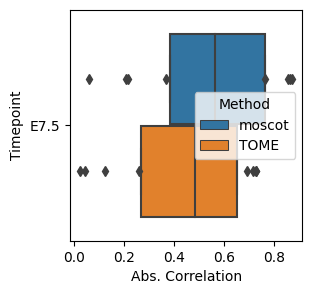

In [21]:
fig, ax = plt.subplots(ncols=1, figsize=(3, 3))
sns.boxplot(data=DF, x="Abs. Correlation", y="Timepoint", hue='Method', showfliers=True,
               showmeans=False,  whis=[100,0], ax=ax)

In [22]:
DF.to_pickle(f'{Path}/Correlations/{ts0}_PEC.npy')